Welcome to the training notebook for the Urban Sound Classification project (NAML-2024 project by Lorenzo Gentile). 

To begin, make sure you have the following modules (the versions listed are the ones tested, may also work on others):
- tensorflow 2.13
- numpy 1.23.5
- pandas 2.0.3
- librosa 0.10.0
- matplotlib 3.7.1
- scikit-learn 1.2.2

In [1]:
import tensorflow as tf

import datetime

print("TensorFlow version: ", tf.__version__)

print(tf.config.list_physical_devices())

# this line disables GPU. For small models, CPU is faster
#tf.config.set_visible_devices([], 'GPU')

tf.keras.utils.set_random_seed(42) # for reproducibility

TensorFlow version:  2.14.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


We will be using two datasets for this project:
- The UrbanSound8K dataset, which contains 8732 labeled sound samples from 10 different classes.
- The ESC-50 dataset, which contains 2000 labeled sound samples from 50 different classes. Only 10 classes are urban sounds, (this subset is called ESC-10), but we will also test the model on the full ESC-50 dataset, to see how it performs on a larger dataset.

In the next block of code, we will define the functions to load the datasets.
Since the 2 datasets have a different folder structure, we will define 2 separate functions. 

In [19]:
PREPROCESSING_PARAMS = {
    # Dataset parameters
    'DATASET_NAME': 'ESC-10', # Choose between 'ESC-10' and 'UrbanSound8K'
    'URBANSOUND8K_TESTFOLD': 10, # Choose between 1 and 10
    'ESC_TESTFOLD': 5, # Choose between 1 and 5
    'WHOLE_ESC_50': True, # If True, the whole ESC-50 dataset is used instead of ESC-10
    'TARGET_SR': 16000,
    
    'DATA_AUGMENTATION': True, # True activates data augmentation, False deactivates it
    'AUGMENTATION_FACTOR': 1, # Increase the number of samples by this factor (e.g. 0.5 means 50% more samples)
    # Add noise
    'ADD_NOISE': True, # True activates noise addition, False deactivates it
    'NOISE_TYPES': ['white', 'pink'], 
    'NOISE_LEVELS': [0.01, 0.01],
    'NOISE_PROBS': [0.5, 0.5],

    # Time shifting
    'TIME_SHIFT' : True, # True activates time shifting, False deactivates it
    'MAX_SHIFT': 0.5, # Maximum time shift in seconds

    # Time stretching
    'TIME_STRETCH': True, # True activates time stretching, False deactivates it
    'STRETCH_RANGE': (0.85, 1.15),  # 1 means no stretching

    # Pitch shifting
    'PITCH_SHIFT': True, # True activates pitch shifting, False deactivates it
    'PITCH_RANGE': (-1, 1), # Maximum pitch shift in semitones

    # Audio transforms
    '2D_TRANSFORMS': ['log_mel_spectrogram'], # Choose between 'spectrogram', 'mel_spectrogram', 'log_mel_spectrogram', 'mfcc', 'scalogram'
    '1D_TRANSFORMS': [], 
    
    # Spectrogram parameters
    'FRAME_LENGTH': 1024,
    'FRAME_STEP': 256,
    'FFT_LENGTH': 1024,

    # MFCC parameters
    'NUM_MEL_BINS': 64,
    'NUM_MFCCS': 64,

    # Wavelet parameters
    'NUM_SCALES': 64,
    'CWT_WAVELET': 'morl',
    'DWT_WAVELET': 'sym2',

    # Normalization
    'NORMALIZATION': 'min_max', # Choose between 'mean_std', 'min_max', 'per_feature_mean_std', and 'none'
}

SAVED_MODELS_DIR = 'saved_models/'


In [20]:
TRAINING_PARAMS = {
    'TRAIN_SPLIT': 0.92,
    'BATCH_SIZE': 16,
    'SHUFFLE_BUFFER_PERCENT': 1,
    'NUM_EPOCHS': 50,
    'LEARNING_RATE': 0.003,
    'EARLY_STOPPING_PATIENCE': 4,
    'DROPOUT_RATE': 0.2
}

In [21]:
from scripts.dataset_loading import load_dataset

# Load the audio dataset
train_val_ds, test_ds, class_names = load_dataset(PREPROCESSING_PARAMS)

# Get the number of samples in the dataset
num_train_val_samples = len(train_val_ds)

# Get the number of classes in the dataset
num_classes = len(class_names)

# Display the class names
print(f"Class names: {class_names}")

Class names: ['clapping' 'pouring_water' 'train' 'sneezing' 'clock_alarm' 'engine'
 'crying_baby' 'crackling_fire' 'helicopter' 'keyboard_typing'
 'chirping_birds' 'pig' 'glass_breaking' 'insects' 'thunderstorm' 'cat'
 'car_horn' 'water_drops' 'drinking_sipping' 'frog' 'sea_waves'
 'breathing' 'sheep' 'vacuum_cleaner' 'snoring' 'chainsaw' 'hen'
 'door_wood_creaks' 'footsteps' 'washing_machine' 'siren' 'wind'
 'can_opening' 'airplane' 'toilet_flush' 'crickets' 'rooster' 'clock_tick'
 'coughing' 'rain' 'brushing_teeth' 'mouse_click' 'cow' 'dog' 'hand_saw'
 'church_bells' 'crow' 'door_wood_knock' 'laughing' 'fireworks']


Now we will pad the audio samples to the maximum length in the whole dataset. This is done to ensure that all samples have the same length, which is required by the neural network, which accepts only fixed-size inputs.


In [22]:
from scripts.audio_preprocessing import apply_padding

# Pad the train_validation dataset and the test dataset
train_val_ds = apply_padding(train_val_ds, PREPROCESSING_PARAMS)
test_ds = apply_padding(test_ds, PREPROCESSING_PARAMS)

In [23]:
# Split the train_val_ds into a training dataset and a validation dataset
train_split = TRAINING_PARAMS['TRAIN_SPLIT']
num_train_samples = int(train_split * num_train_val_samples)

train_ds = train_val_ds.take(num_train_samples)
val_ds = train_val_ds.skip(num_train_samples)

In [24]:
from scripts.audio_preprocessing import augment_audio_dataset

# Augment the training dataset
if PREPROCESSING_PARAMS['DATA_AUGMENTATION']:
    train_ds = augment_audio_dataset(train_ds, PREPROCESSING_PARAMS)
    
old_num_train_samples = num_train_samples
num_train_samples = len(train_ds)

Number of training samples before augmentation: 1472
Number of training samples after augmentation: 2944
Audio shape (original): (80000,)
Audio shape (augmented): (80000,)


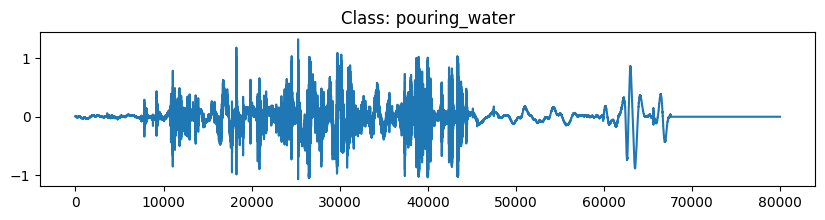

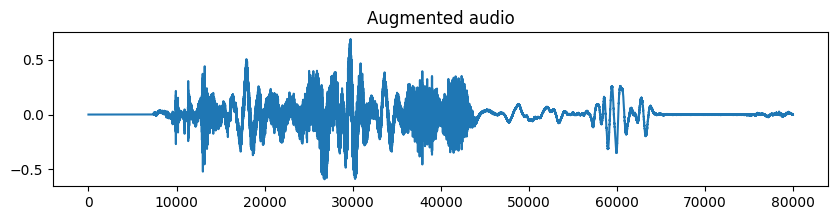

Audio shape (original): (80000,)
Audio shape (augmented): (80000,)


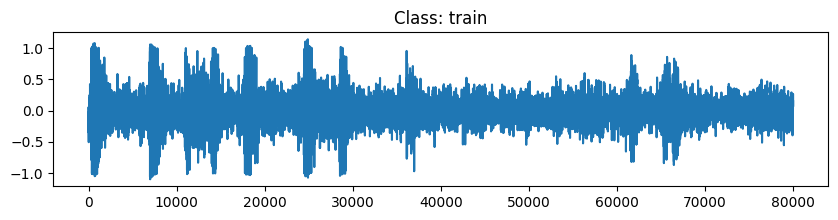

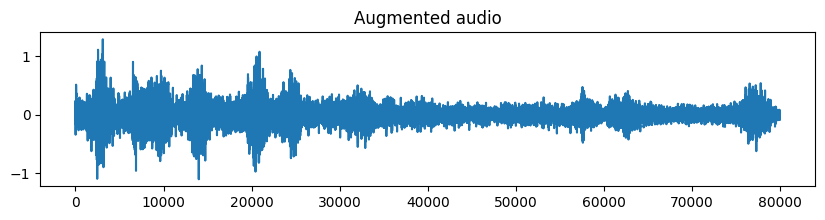

Audio shape (original): (80000,)
Audio shape (augmented): (80000,)


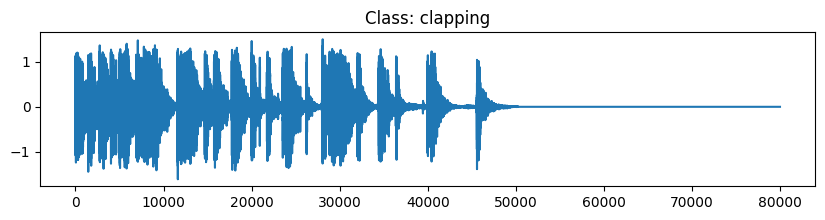

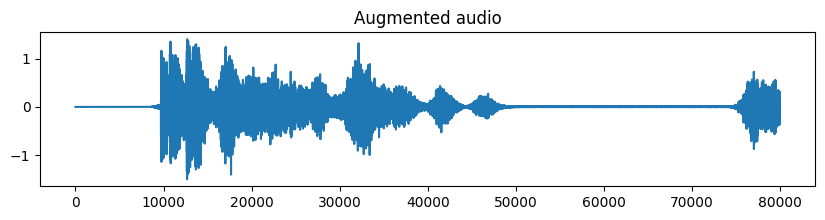

Audio shape (original): (80000,)
Audio shape (augmented): (80000,)


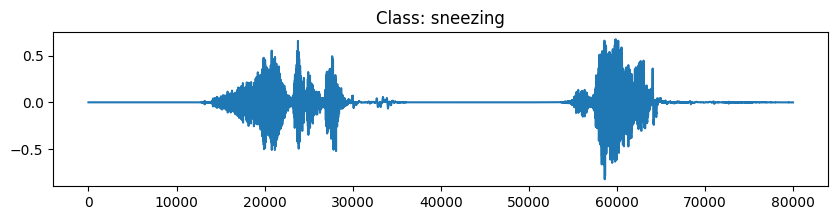

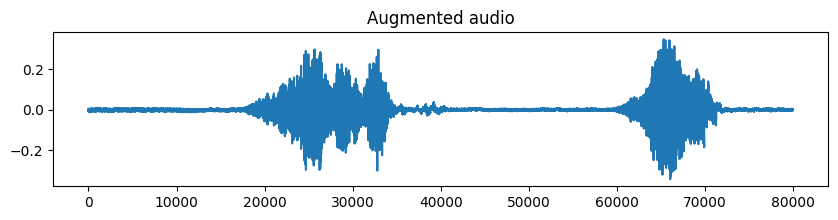

Audio shape (original): (80000,)
Audio shape (augmented): (80000,)


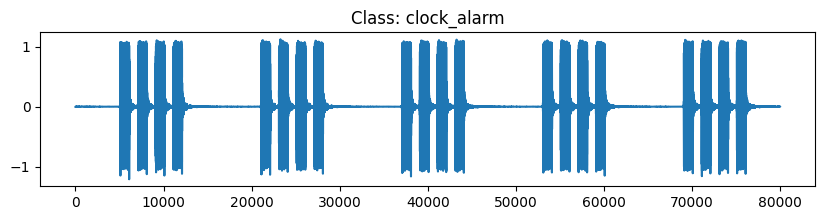

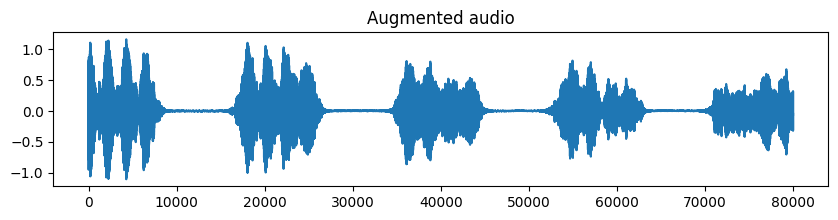

Audio shape (original): (80000,)
Audio shape (augmented): (80000,)


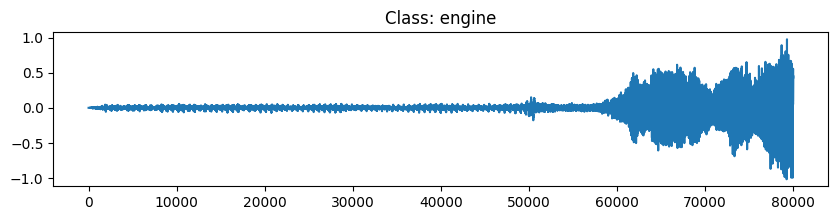

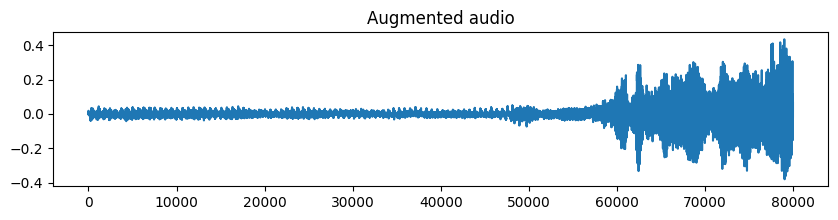

Audio shape (original): (80000,)
Audio shape (augmented): (80000,)


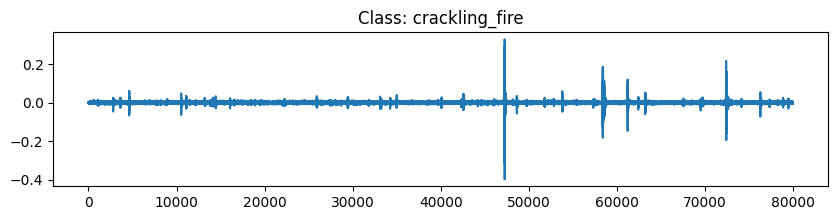

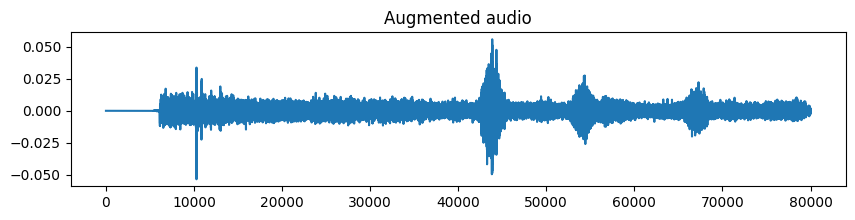

Audio shape (original): (80000,)
Audio shape (augmented): (80000,)


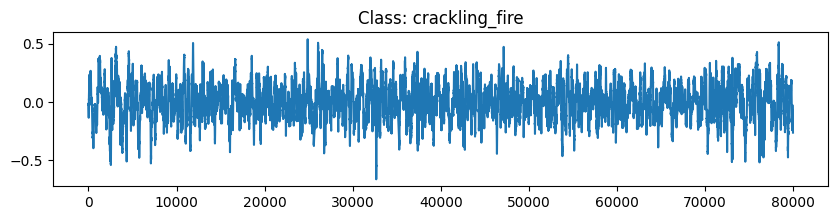

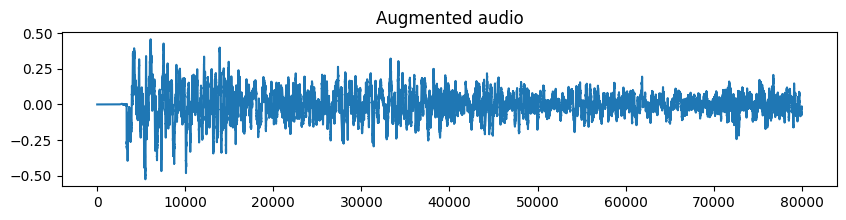

Audio shape (original): (80000,)
Audio shape (augmented): (80000,)


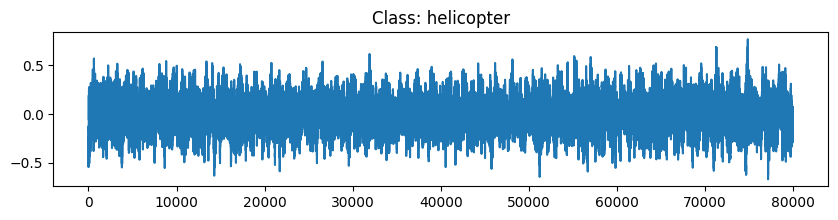

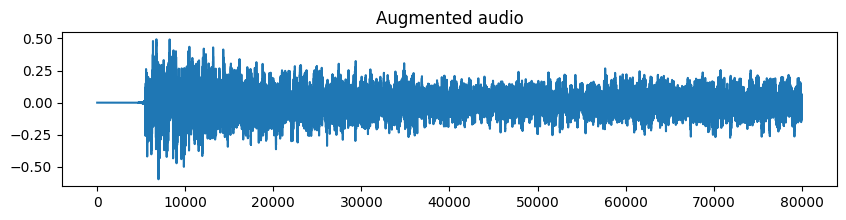

Audio shape (original): (80000,)
Audio shape (augmented): (80000,)


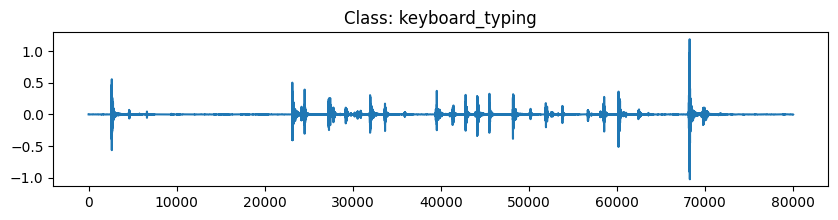

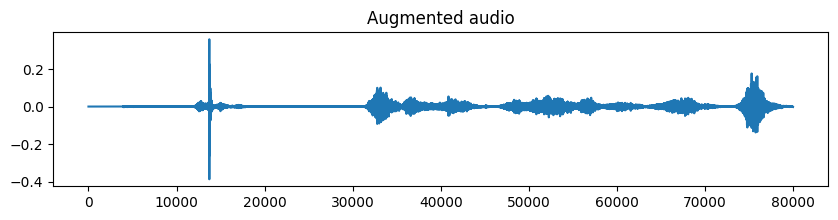

In [25]:
from scripts.plotting_utils import plot_waveforms

plot_waveforms(train_ds, class_names, PREPROCESSING_PARAMS, old_num_train_samples, num_train_samples, 10)

In [26]:
from scripts.audio_preprocessing import transform_normalize_dataset

# Transform and normalize the datasets
train_ds = transform_normalize_dataset(train_ds, PREPROCESSING_PARAMS)
val_ds = transform_normalize_dataset(val_ds, PREPROCESSING_PARAMS)
test_ds = transform_normalize_dataset(test_ds, PREPROCESSING_PARAMS)

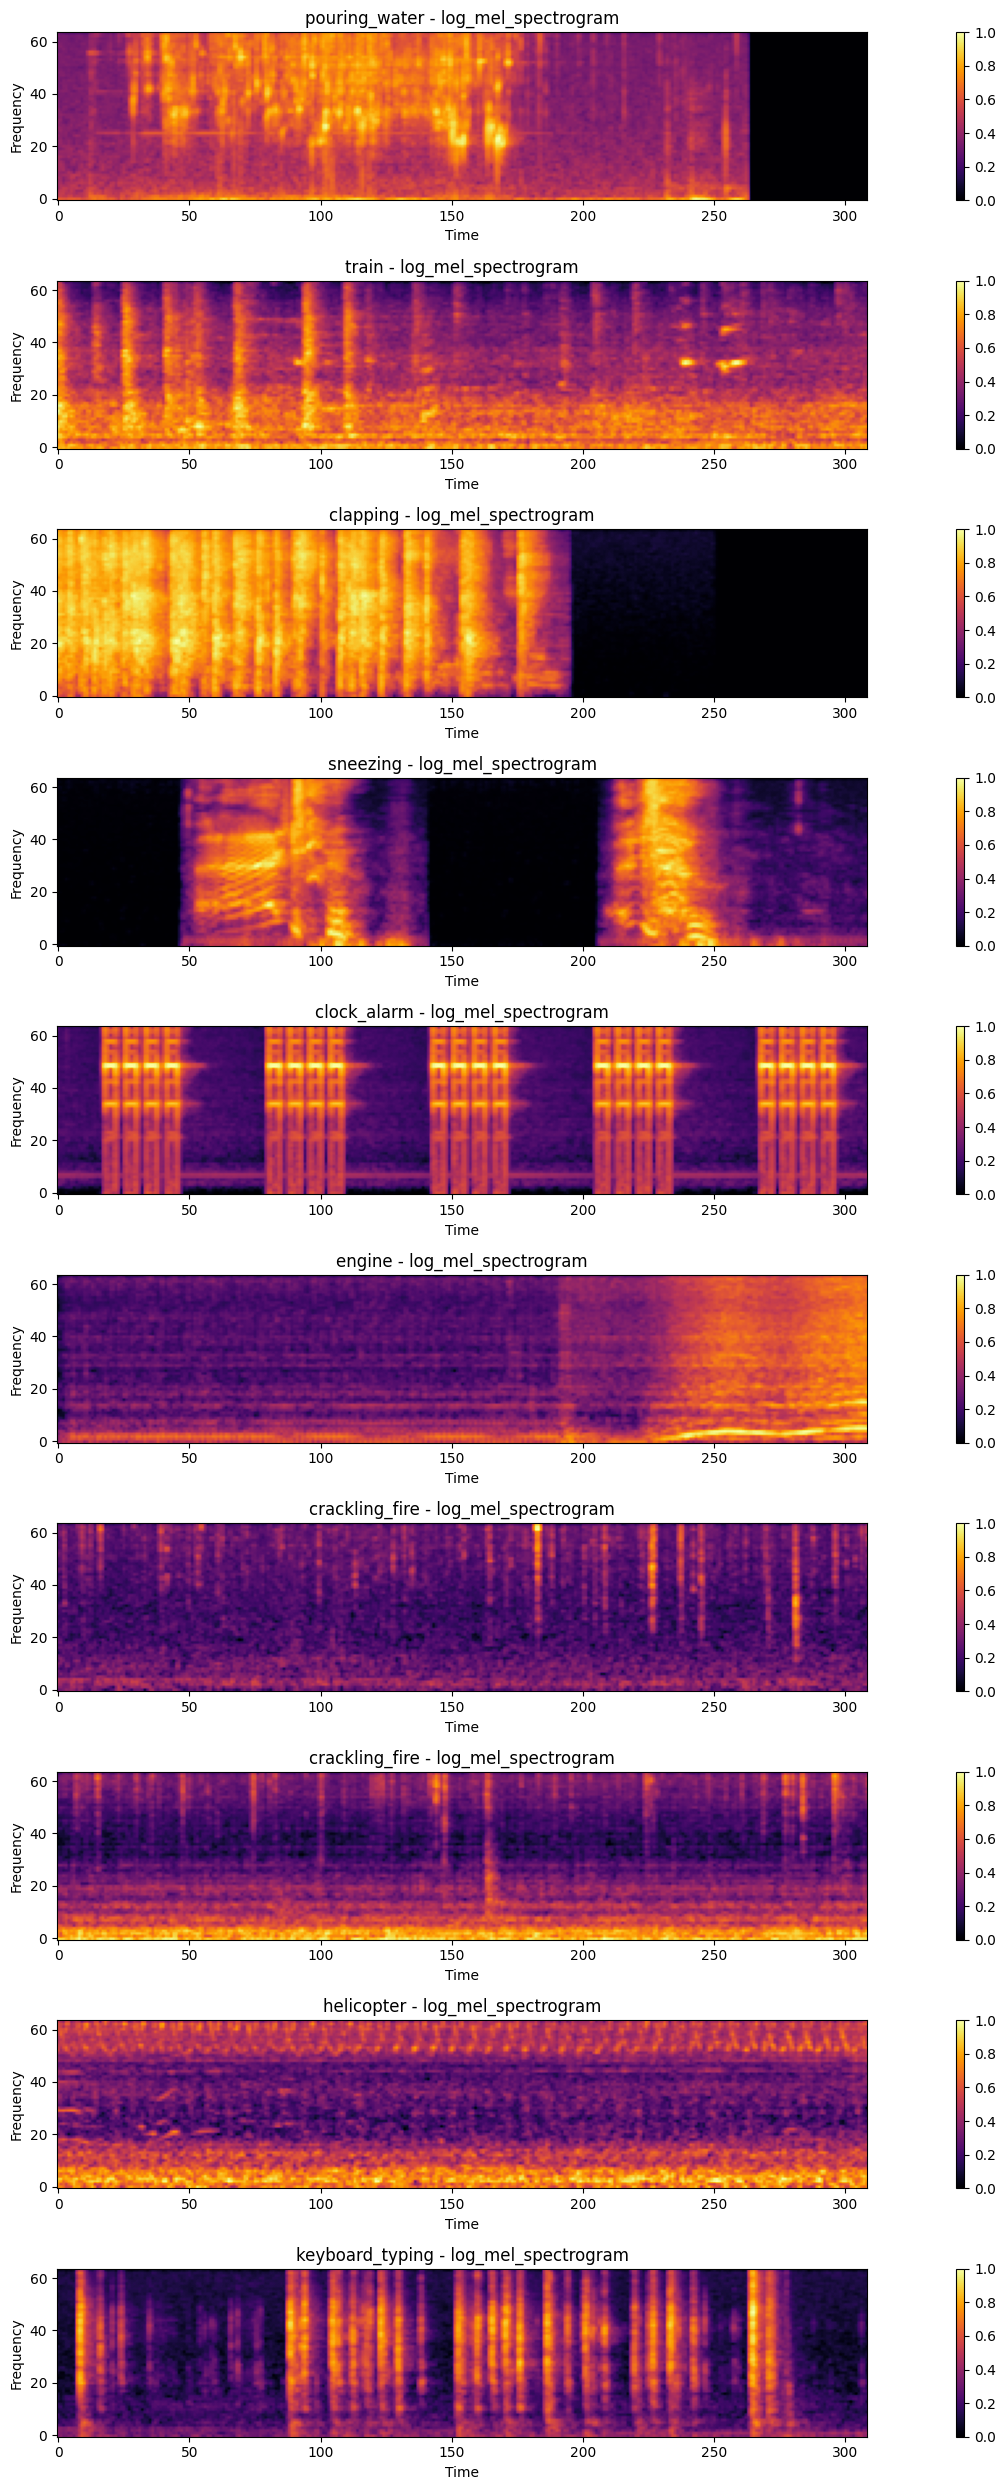

In [27]:
from scripts.plotting_utils import plot_transforms

# Plot the first 6 audio clips in the training set
plot_transforms(train_ds, class_names, PREPROCESSING_PARAMS, 10)

In the next block of code, we split the data into training, validation, and test sets and we batch the data. Splitting coefficients and batch size are modifiable hyperparameters.

In [28]:
batch_size = TRAINING_PARAMS['BATCH_SIZE']
shuffle_buffer_percent = TRAINING_PARAMS['SHUFFLE_BUFFER_PERCENT']

# Calculate the number of samples in the training, validation, and test sets
num_train_samples = len(train_ds)
shuffle_buffer_size = int(num_train_samples * shuffle_buffer_percent)

# Cache the datasets
train_ds = train_ds.cache()
val_ds = val_ds.cache()
test_ds = test_ds.cache()

# Shuffle the training dataset
train_ds = train_ds.shuffle(shuffle_buffer_size)

# Batch the datasets
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

# Prefetch the datasets
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [29]:
num_2d_transforms = len(PREPROCESSING_PARAMS['2D_TRANSFORMS'])
num_1d_transforms = len(PREPROCESSING_PARAMS['1D_TRANSFORMS'])

input_shapes_2d = [next(iter(test_ds))[0][i].shape[1:] for i in range(num_2d_transforms)]
input_shapes_1d = [next(iter(test_ds))[0][i + num_2d_transforms].shape[1:] for i in range(num_1d_transforms)]

print(f"2D input shapes: {input_shapes_2d}")
print(f"1D input shapes: {input_shapes_1d}")

2D input shapes: [TensorShape([309, 64, 1])]
1D input shapes: []


2024-05-07 21:20:30.305559: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 309, 64, 1)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 309, 64, 16)       784       
                                                                 
 batch_normalization_6 (Bat  (None, 309, 64, 16)       64        
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 309, 64, 16)       0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 77, 32, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 77, 32, 32)        1280

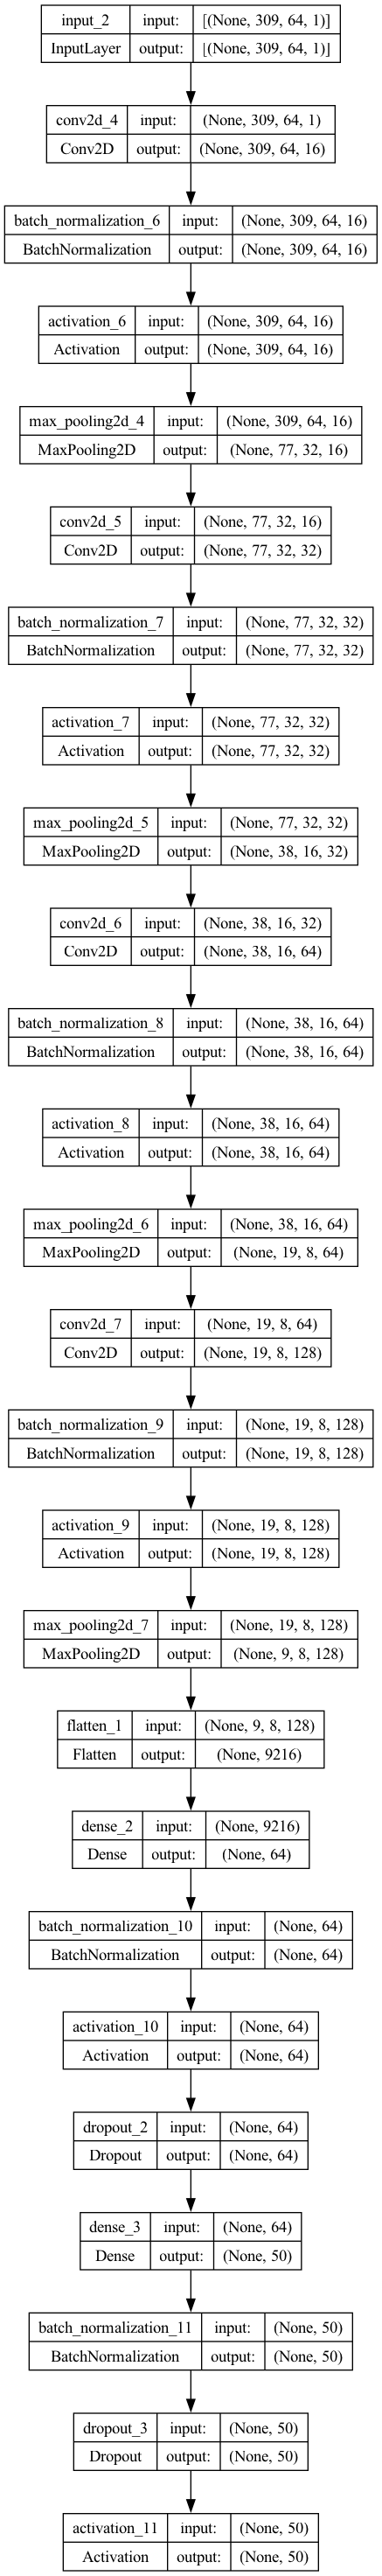

In [30]:
dropout_rate = TRAINING_PARAMS['DROPOUT_RATE']
#dropout_rate = 0.3

dropout_after_conv = False

# Define inputs for each of the transforms
inputs_2d = [tf.keras.layers.Input(shape=input_shape) for input_shape in input_shapes_2d]
inputs_1d = [tf.keras.layers.Input(shape=input_shape) for input_shape in input_shapes_1d]

filter_sizes = [(7, 7), (5, 5)]
pool_sizes = [(4, 2), (3, 2)]

# Define the first convolutional layers for each of the 2D inputs
conv = [tf.keras.layers.Conv2D(16, filter_size, use_bias=False, padding='same')(input_2d) for input_2d, filter_size in zip(inputs_2d, filter_sizes)]
batch_norm = [tf.keras.layers.BatchNormalization()(conv) for conv in conv]
activation = [tf.keras.layers.Activation('relu')(batch) for batch in batch_norm]
if dropout_after_conv:
    dropout = [tf.keras.layers.Dropout(dropout_rate)(activation) for activation in activation]
else:
    dropout = activation
maxpool = [tf.keras.layers.MaxPooling2D(pool_size)(drop) for drop, pool_size in zip(dropout, pool_sizes)]

filter_sizes = [(5, 5), (3, 3)]
pool_sizes = [(2, 2), (5, 6)]

# Define the second convolutional layers
conv = [tf.keras.layers.Conv2D(32, filter_size, use_bias=False, padding='same')(pool) for pool, filter_size in zip(maxpool, filter_sizes)]
batch_norm = [tf.keras.layers.BatchNormalization()(conv) for conv in conv]
activation = [tf.keras.layers.Activation('relu')(batch) for batch in batch_norm]
if dropout_after_conv:
    dropout = [tf.keras.layers.Dropout(dropout_rate)(activation) for activation in activation]
else:
    dropout = activation
maxpool = [tf.keras.layers.MaxPooling2D(pool_size)(drop) for drop, pool_size in zip(dropout, pool_sizes)]

filter_sizes = [(3, 3), (3, 3)]
pool_sizes = [(2, 2), (3, 3)]

# Define the third convolutional layers
conv = [tf.keras.layers.Conv2D(64, filter_size, use_bias=False, padding='same')(pool) for pool, filter_size in zip(maxpool, filter_sizes)]
batch_norm = [tf.keras.layers.BatchNormalization()(conv) for conv in conv]
activation = [tf.keras.layers.Activation('relu')(batch) for batch in batch_norm]
if dropout_after_conv:
    dropout = [tf.keras.layers.Dropout(dropout_rate)(activation) for activation in activation]
else:
    dropout = activation
maxpool = [tf.keras.layers.MaxPooling2D(pool_size)(drop) for drop, pool_size in zip(dropout, pool_sizes)]

filter_sizes = [(3, 3), (3, 3)]
pool_sizes = [(2, 1), (2, 2)]

# Define the fourth convolutional layers
conv = [tf.keras.layers.Conv2D(128, filter_size, use_bias=False, padding='same')(pool) for pool, filter_size in zip(maxpool, filter_sizes)]
batch_norm = [tf.keras.layers.BatchNormalization()(conv) for conv in conv]
activation = [tf.keras.layers.Activation('relu')(batch) for batch in batch_norm]
if dropout_after_conv:
    dropout = [tf.keras.layers.Dropout(dropout_rate)(activation) for activation in activation]
else:
    dropout = activation
maxpool = [tf.keras.layers.MaxPooling2D(pool_size)(drop) for drop, pool_size in zip(dropout, pool_sizes)]

# filter_sizes = [(3, 3), (3, 3)]
# pool_sizes = [(1, 1), (2, 2)]

# # Define the fifth convolutional layers
# conv = [tf.keras.layers.Conv2D(128, filter_size, use_bias=False, padding='same')(pool) for pool, filter_size in zip(maxpool, filter_sizes)]
# batch_norm = [tf.keras.layers.BatchNormalization()(conv) for conv in conv]
# activation = [tf.keras.layers.Activation('relu')(batch) for batch in batch_norm]
# if dropout_after_conv:
#     dropout = [tf.keras.layers.Dropout(dropout_rate)(activation) for activation in activation]
# else:
#     dropout = activation
# maxpool = [tf.keras.layers.MaxPooling2D(pool_size)(drop) for drop, pool_size in zip(dropout, pool_sizes)]


# Flatten the output of the convolutional layers
flatten = [tf.keras.layers.Flatten()(pool) for pool in maxpool]
#flatten = [tf.keras.layers.GlobalAveragePooling2D()(drop) for drop in drop]

# Conditionally concatenate the flattened outputs and the 1D inputs
if num_2d_transforms > 1:
    concat = tf.keras.layers.Concatenate()(flatten)
elif num_1d_transforms > 0:
    concat = tf.keras.layers.Concatenate()(flatten + inputs_1d)
else:
    concat = flatten[0]

# Define the first dense layer
dense = tf.keras.layers.Dense(64)(concat)
batch_norm = tf.keras.layers.BatchNormalization()(dense)
activation = tf.keras.layers.Activation('relu')(batch_norm)
dropout = tf.keras.layers.Dropout(dropout_rate)(activation)

# Define the second dense layer
dense = tf.keras.layers.Dense(num_classes)(dropout)
batch_norm = tf.keras.layers.BatchNormalization()(dense)
dropout = tf.keras.layers.Dropout(dropout_rate)(batch_norm)

# Define the softmax activation function
softmax = tf.keras.layers.Activation('softmax')(dropout)

# Define the model
model = tf.keras.models.Model(inputs=inputs_2d + inputs_1d, outputs=softmax)

# Display the model summary and plot the model
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [31]:
learning_rate = TRAINING_PARAMS['LEARNING_RATE']

# Compile the model
model.compile(tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
                metrics=['accuracy'])

In [32]:
import keras.callbacks as callbacks
from keras.callbacks import Callback

# Define callbacks
early_stopping_patience = TRAINING_PARAMS['EARLY_STOPPING_PATIENCE']

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min",
                                        patience=early_stopping_patience,
                                        restore_best_weights=True)

class TestSetEvaluation(Callback):
    def __init__(self, test_data):
        super().__init__()
        self.test_data = test_data
        self.test_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_accuracy = self.model.evaluate(self.test_data, verbose=0)
        self.test_accuracies.append(test_accuracy)
        print(f'\nEpoch {epoch+1}: Test accuracy: {test_accuracy:.4f}')

# Instantiate the callback with your test dataset
test_set_evaluation_callback = TestSetEvaluation(test_ds)

In [33]:
# Train the model
num_epochs = TRAINING_PARAMS['NUM_EPOCHS']

model.fit(train_ds,
          validation_data=val_ds,
          epochs=num_epochs,
          callbacks=[tensorboard_callback
                        , earlystopping
                    #    , test_set_evaluation_callback
                        ])

Epoch 1/50


2024-05-07 21:20:42.805267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:64: Filling up shuffle buffer (this may take a while): 1300 of 2944
2024-05-07 21:20:52.908245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:64: Filling up shuffle buffer (this may take a while): 1611 of 2944
2024-05-07 21:21:12.944133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:64: Filling up shuffle buffer (this may take a while): 1962 of 2944
2024-05-07 21:21:32.807875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:64: Filling up shuffle buffer (this may take a while): 2309 of 2944
2024-05-07 21:21:42.816260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:64: Filling up shuffle buffer (this may take a while): 2487 of 2944
2024-05-07 21:21:52.830577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:64: Filling up shuffle buffer (this may ta

184/184 [==============================] - 139s 183ms/step - loss: 3.5002 - accuracy: 0.1298 - val_loss: 4.2456 - val_accuracy: 0.0469
Epoch 2/50
184/184 [==============================] - 22s 119ms/step - loss: 2.9356 - accuracy: 0.2582 - val_loss: 3.3310 - val_accuracy: 0.1484
Epoch 3/50
184/184 [==============================] - 21s 113ms/step - loss: 2.7000 - accuracy: 0.3302 - val_loss: 2.5947 - val_accuracy: 0.3125
Epoch 4/50
184/184 [==============================] - 21s 113ms/step - loss: 2.4712 - accuracy: 0.4079 - val_loss: 2.4996 - val_accuracy: 0.3359
Epoch 5/50
184/184 [==============================] - 21s 112ms/step - loss: 2.3342 - accuracy: 0.4518 - val_loss: 2.9312 - val_accuracy: 0.2188
Epoch 6/50
184/184 [==============================] - 21s 112ms/step - loss: 2.1505 - accuracy: 0.4949 - val_loss: 2.0098 - val_accuracy: 0.4453
Epoch 7/50
184/184 [==============================] - 20s 111ms/step - loss: 2.0248 - accuracy: 0.5438 - val_loss: 2.1921 - val_accuracy: 0.

In [35]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

25/25 [==============================] - 2s 74ms/step - loss: 1.9752 - accuracy: 0.4975


In [ ]:
from scripts.model_utils import save_model

# Save the model
save_model(model, SAVED_MODELS_DIR, PREPROCESSING_PARAMS, TRAINING_PARAMS, test_accuracy)